# DataSet #2: Mobilitat entre Municipis

Autor: Marc Bosch Manzano<br>
Data: Octubre 2025<br>
Iteració: 2a<br>
Projecte: MobiCat

Assignació: Farith, Jesús

## Anàlisi dels Municipis amb Grafs

### Importació de Llibreries

In [13]:
PACKAGES = ["pandas", "matplotlib", "networkx", "numpy", "geopandas"]
COLORS = ["viridis", "plasma", "inferno", "magma", "cividis"]

import os
import importlib
import sys
sys.path.append('../mobicat_python_utils')

import utils
importlib.reload(utils)
utils.install_missing_packages(PACKAGES)

import numpy as np
import pandas as pd 
import geopandas as gpd
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import networkx as nx

import IPython.display 
IPython.display.clear_output()

In [14]:
def min_max_normalization(array):
    return (array - np.min(array)) / (np.max(array) - np.min(array))

def min_max(value, min, max):
    return (value - min) / (max - min)

def z_score(value, mean, std_dev):
    return (value - mean) / std_dev

def linear_transformation(array, scaling, translation):
    return scaling * array + translation

def quadratic_transformation(array, quadratic_term, linear_term, constant_term):
    return quadratic_term * array**2 + linear_term * array + constant_term

def select_great_than_equal(array, threshold):
    return array * (array >= threshold)

### Importació de les Dades

**Important**: importa al directori *test-data* els següents fitxers o canviar el directori pel directori amb els fitxers. 
```bash
    movilidad_barrios_2023-01_origen.csv
    movilidad_municipios_2023-01_origen.csv
    movilidad_mun_barrios_2023-01_origen.csv
```

Importem el dataframe de mobilitat de municipis en d'un mes. Les descripcions de les dades de mobilitat de Telefónica estan al PDF [Metadata Mobile Data Challenge DataSets 2025.pdf](./test-data/Metadata%20Mobile%20Data%20Challenge%20DataSets%202025.pdf). Li apliquem un filtre d'escollir els viatges majors a 0.

In [15]:
mobility_directory = "./test-data/"
mobility_file_name = "movilidad_municipios_2023-01_origen.csv"
mobility_file_path = os.path.join(mobility_directory, mobility_file_name)

mobility_df = pd.read_csv(mobility_file_path, dtype=str)
mobility_df["viajes"] = mobility_df["viajes"].astype(int)
mobility_df["day"] = pd.to_datetime(mobility_df["day"])
mobility_df = mobility_df[mobility_df["viajes"] > 0]

Importem el dataframe de les cartografies dels punts on estan els caps dels municipis de l'ICGC, és a dir, les ubicacions geogràfiques dels ajuntaments dels pobles. Les descripcions d'aquestes dades estan al següent PDF [divisions-administratives-v2r1-20250207.pdf](../catalonia-geography-maps/icgc/divisions-administratives-v2r1-20250207.pdf).

In [16]:
complementary_directory = "../catalonia-geography-maps/icgc/divisions-administratives-v2r1-20250730/"

municipis_name = "divisions-administratives-v2r1-municipis-5000-20250730.shp"
caps_municipi_name = "divisions-administratives-v2r1-caps-municipi-20250730.shp"

municipis_path = os.path.join(complementary_directory, municipis_name) 
caps_municipi_path = os.path.join(complementary_directory, caps_municipi_name)

municipis_df = gpd.read_file(municipis_path) 
caps_municipi_df = gpd.read_file(caps_municipi_path)

if False:
    display(municipis_df.drop(columns="geometry").sample(5))
    print(municipis_df.shape)

    display(caps_municipi_df.sample(5))
    print(caps_municipi_df.shape)

### Construcció de les Arestes

En aquest apartat treballarem amb al dataframe de mobilitat.

Per tal de construir el graf dels municipis relacionats pels desplaçaments entre si, agrupem les dades de mobilitat per municipi d'origen i de destí. Això ens produirà un graf dirigit ponderat, hi haurà diferent quantitat d'arestes que entren a cada node de les que surten. També els pesos variaran entre les arestes entrants i sortints. 

Definim un graf d'arestes no dirigides ponderades que on el pes de l'aresta dirigida és la suma de pesos de les arestes entrants i aresta sortints.

In [17]:
mobility_directed_edges_df = utils.group_by_origin_destination_directed(mobility_df)
mobility_undirected_edges_df = utils.group_by_origin_destination_undirected(mobility_df)

edge_reduction = 1 - mobility_undirected_edges_df.shape[0] / mobility_directed_edges_df.shape[0]

display(mobility_undirected_edges_df.sample(5))
print(mobility_undirected_edges_df.shape)
print("Number of edges reduced respect directed edges: %.2f%%" % (100 * edge_reduction))

,municipio_1,municipio_2,viajes
1391,08017,08037,945
7958,08113,08255,102
1623,08019,08026,117
7571,08108,08193,23
7418,08106,08289,32


(13200, 3)
Number of edges reduced respect directed edges: 43.02%


### Construcció dels Nodes

Per tal de construir els nodes, que són els municipis, necessitarem els següents dataframes:

1) Dades de Mobilitat: Obtenir la suma de viatges total per municipi agrupant per municipi d'origen i destí per separat i després sumant-ho.
2) Dades de Caps de Municipi: Obtenir les dades de les ubicacions geogràfiques dels municipis.
3) Dades de Municipis: Només l'utilitzarem per obtenir les dades dels noms dels municipis i altres dades addicionals com la comarca, província, etc.
3) Dades Demogràfiques: Obtenir les dades de la població de cada municipi.

Finalment, les unim totes en un sol dataframe amb un minicipi per fila.

Comencem per (1) Dades de Mobilitat.

In [18]:
mobility_nodes_df = utils.group_by_municipality(mobility_df)

Seguim per (2) (3) les Dades Geogràfiques.

In [19]:
municipis_filtered_df = gpd.GeoDataFrame(municipis_df[municipis_df["NOMPROV"] == "Barcelona"])
municipis_filtered_df = municipis_filtered_df[["CODIMUNI", "NOMMUNI"]]

caps_municipi_filtered_df = gpd.GeoDataFrame(caps_municipi_df[["CODIMUNI", "geometry"]])

municipi_merged_df = municipis_filtered_df\
    .join(
        other=caps_municipi_filtered_df.set_index("CODIMUNI"),
        on="CODIMUNI"
    )

municipi_merged_df = gpd.GeoDataFrame(municipi_merged_df)

municipi_merged_df["municipio_name"] = municipi_merged_df["NOMMUNI"]
municipi_merged_df["municipio"] = utils.ine_to_idescat(municipi_merged_df["CODIMUNI"])
municipi_merged_df["point_x"] = min_max_normalization(municipi_merged_df["geometry"].x)
municipi_merged_df["point_y"] = min_max_normalization(municipi_merged_df["geometry"].y)

municipi_merged_df = municipi_merged_df[["municipio", "municipio_name", "point_x", "point_y"]]

Unim (1) amb (2) i (3).

In [20]:
mobility_nodes_merged_df = municipi_merged_df\
    .join(
        other=mobility_nodes_df.drop(columns="municipio_name").set_index("municipio"),
        on="municipio",
        how="inner"
    )

display(mobility_nodes_merged_df.sample(5))
print(mobility_nodes_merged_df.shape)

,municipio,municipio_name,point_x,point_y,viajes
106,08107,Lliçà d'Amunt,0.616688,0.371225,789283
259,08262,Sant Vicenç de Castellet,0.337081,0.424920,294659
174,08176,Pujalt,0.006329,0.478007,7189
281,08284,Tordera,0.976804,0.453689,335729
15,08016,Bagà,0.343405,0.973270,159538


(303, 5)


### Filtre de les Arestes i Nodes

Ens quedem amb les arestes del percentil superior per nombre de viatjants. Filtrem els nodes d'aquest percentil d'arestes.

In [21]:
edges_df = pd.DataFrame(mobility_undirected_edges_df)
nodes_df = gpd.GeoDataFrame(mobility_nodes_merged_df)

percentile = 0.50
edges_df = edges_df[edges_df["viajes"] > edges_df["viajes"].quantile(percentile)]

unique_nodes_df = pd.concat([edges_df["municipio_1"], edges_df["municipio_2"]]).unique()
nodes_df = nodes_df[nodes_df["municipio"].isin(unique_nodes_df)]

display(edges_df.tail(5))
print(edges_df.shape)

display(nodes_df.tail(5))
print(nodes_df.shape)

,municipio_1,municipio_2,viajes
13190,08302,08307,935
13191,08304,08305,16258
13192,08304,08307,1182
13193,08305,08307,179483
13196,08305,08905,440


(6600, 3)


,municipio,municipio_name,point_x,point_y,viajes
306,08901,Rupit i Pruit,0.789165,0.755116,2221
307,08902,Vilanova del Vallès,0.654538,0.317784,240882
308,08903,Sant Julià de Cerdanyola,0.365964,0.945774,859
309,08904,Badia del Vallès,0.522236,0.276814,224734
310,08905,la Palma de Cervelló,0.413599,0.187209,180872


(300, 5)


In [22]:
bins = [0, 1e5, 5e5, 1e6, 5e6, 1e7, float("inf")]

nodes_df["quantile"] = pd.cut(
    nodes_df["viajes"],
    bins=bins,
    labels=range(0, len(bins) - 1),
    include_lowest=True
).astype(int) / (len(bins) - 2)

In [24]:
# num_quantiles = 7

# nodes_df["quantile"] = pd.qcut(
#     nodes_df["viajes"],
#     q=num_quantiles,
#     labels=range(0, num_quantiles)
# ).astype(int) / (num_quantiles - 1)

In [25]:
G = nx.Graph()

# nodes_df["node_color"] = linear_transformation(min_max_normalization(np.log(select_great_than_equal(nodes_df["viajes"], 20000) + 1)**3), 0.8, 0.3)
nodes_df["node_color"] = linear_transformation(nodes_df["quantile"], 0.8, 0.1)
# nodes_df["node_size"] = linear_transformation(min_max_normalization(np.log(select_great_than_equal(nodes_df["viajes"], 20000) + 1)**6), 450, 10)
nodes_df["node_size"] = quadratic_transformation(nodes_df["quantile"], 400, 0, 30)

edges_df["edge_color"] = linear_transformation(min_max_normalization(np.sqrt(np.log(edges_df["viajes"] + 1))), 0.55, 0.15)
edges_df["edge_width"] = linear_transformation(min_max_normalization(np.log(edges_df["viajes"] + 1)**2), 2, 0.5) 

nodes_df["node_color"] = nodes_df["node_color"].apply(matplotlib.colormaps.get_cmap("Blues_r")) 
edges_df["edge_color"] = edges_df["edge_color"].apply(matplotlib.colormaps.get_cmap("Greys"))

for idx, node in nodes_df.iterrows():
    G.add_node(
        node_for_adding=node["municipio"], 
        pos=np.array([node["point_x"], node["point_y"]], dtype="float32"), 
        node_size=node["node_size"],
        node_color=node["node_color"]
    )

for _, edge in edges_df.iterrows():
    G.add_edge(
        u_of_edge=edge["municipio_1"], 
        v_of_edge=edge["municipio_2"], 
        edge_width=edge["edge_width"],
        edge_color=edge["edge_color"]
    )

In [29]:
graph_nodes = G.nodes(data=True)
nodes_sorted = sorted(graph_nodes, key=lambda data: data[1]["node_size"], reverse=False)
node_position = {node: data["pos"] for node, data in nodes_sorted}
node_color = [data["node_color"] for _, data in nodes_sorted]
node_size = [data["node_size"] for _, data in nodes_sorted]
node_list = [node[0] for node in nodes_sorted]


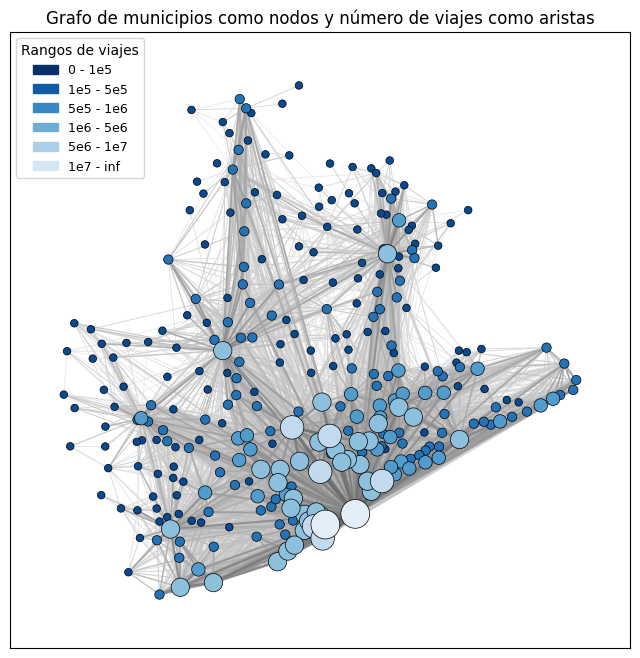

In [ ]:
graph_nodes = G.nodes(data=True)
nodes_sorted = sorted(graph_nodes, key=lambda data: data[1]["node_size"], reverse=False)
node_position = {node: data["pos"] for node, data in nodes_sorted}
node_color = [data["node_color"] for _, data in nodes_sorted]
node_size = [data["node_size"] for _, data in nodes_sorted]
node_list = [node[0] for node in nodes_sorted]

graph_edges = G.edges(data=True)
edge_list = sorted(graph_edges, key=lambda data: data[2]["edge_width"], reverse=False)
edge_width = [data[2]["edge_width"] for data in edge_list]
edge_color = [data[2]["edge_color"] for data in edge_list]

plt.figure(figsize=(8, 8))

nx.draw_networkx_nodes(
    G=G,
    pos=node_position,
    nodelist=node_list,
    node_size=node_size,
    node_color=node_color,
    linewidths=0.5,
    edgecolors="black"
)

nx.draw_networkx_edges(
    G=G,
    pos=node_position,
    edgelist=edge_list,
    width=edge_width,
    edge_color=edge_color
)

plt.title("Grafo de municipios como nodos y número de viajes como aristas")

def format_value(value):
    if value == 0:
        return "0"
    if value ==  float("inf"):
        return "inf"
    else:
        return f"{value:.0e}".replace("+0", "").replace("+", "")
    

bins = [0, 1e5, 5e5, 1e6, 5e6, 1e7, float("inf")]
bins_formatted = [format_value(bin_) for bin_ in bins]

labels = ["%s - %s" % (bins_formatted[i], bins_formatted[i+1]) for i in range(len(bins) - 1)]

cmap = matplotlib.colormaps.get_cmap("Blues_r")
colors = [cmap(i/len(labels)) for i in range(len(labels))]

patches = [mpatches.Patch(color=colors[i], label=labels[i]) for i in range(len(labels))]

plt.legend(
    handles=patches,
    title="Rangos de viajes",
    loc="upper left",
    frameon=True,
    fontsize=9,
    title_fontsize=10
)

plt.show()